<a href="https://colab.research.google.com/github/bogdan-p-s/educational_projects/blob/master/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Исходный срикпт:

In [65]:
df = pd.read_csv('clients.csv')

df_4_cluster = df.copy()
mapper = dict((val, i) for i, val in enumerate(df_4_cluster.sex.unique()))
df_4_cluster['sex'] = df_4_cluster['sex'].map(mapper)

categoricals = dfs.categoricals.tolist()

df_4_cluster = pd.get_dummies(df_4_cluster, columns=categoricals, drop_first=False)

df_4_cluster.drop('month', axis=1, inplace=True)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_4_cluster)
df_scaled = pd.DataFrame(df_scaled, columns=df_4_cluster.columns)

pca = PCA(n_components=0.95, svd_solver='full', random_state=my_seed)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

kmeans = KMeans(n_clusters=7, random_state=my_seed).fit(df_pca)

df['cluster'] = kmeans.labels_



## Рекомендации по технической части скрипта:
- ввиду малокого количества значений некоторых признаков, объединить категории цели кредита в более крупные (например, 'Boats' и 'Fishing and hunting supplies', 'Construction Materials' и т.д. 'Windows & Doors'), аналогично с образованием. Кодирование данных признаков по ОНЕ сильно раздувает датасет, а РСА в первую очередь "сворачивает" признаки с бОльшей дисперсией
- с количеством кластеров равным 7, в некоторые кластеры попадает малое число записей, по которым сложно делать выводы (возможно на больших данных это имеет смысл), можно попробовать k=5
- попробовать использовать метод главных компонент c меньшим значением n_components (сейчас сохранение 95%)
- проанлизировать данные на предмет выбросов
- проанализировать важность признаков, при необходимости исключить

### Анализ и рекомендации бизнесу:
Один из ключевых показателей это надежность клиента:

In [56]:
print('Общий процент "плохих" клиентов: {:.2%}'.format(df.bad_client_target.mean()))
df.pivot_table(index='cluster', values='bad_client_target', aggfunc=('count', 'mean'))

Общий процент "плохих" клиентов: 11.38%


,count,mean
cluster,,
0,30.0,0.133333
1,451.0,0.048780
2,201.0,0.199005
3,355.0,0.121127
4,597.0,0.137353
5,86.0,0.058140
6,3.0,0.000000


- Во-первых, у кластеров 1, 5, да и 6 довольно мало объектов, поэтому делать выводы на таких малых выборках не совсем корректно.
- Во-вторых, мы видим существенную разницу в показателе надежности между группами: фаворит - кластер 4 (если не брать в расчет малочисленный кластер 1)

Взглянем на размер кредита:

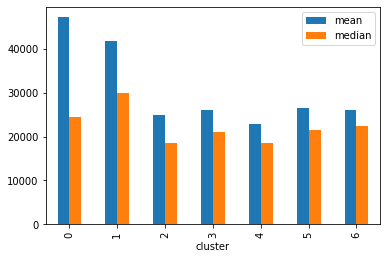

In [67]:
df.pivot_table(index='cluster', values='credit_amount', aggfunc=('mean', 'median')).plot(kind='bar');

Посчитаем потенциальную прибыль с каждой категории, возьмем процент кредита равным 12 (с целью упрощения расчета, берем один процент на всех):

In [68]:
percent = 0.12
risk = df.pivot_table(index='cluster', values='bad_client_target') # доля "плохих" заемщиков
cl_cr_amount = df.pivot_table(index='cluster', values='credit_amount', aggfunc=('median')) # медианная сумма кредита внутри кластера

svod = pd.concat([pd.DataFrame(df.cluster.value_counts()), cl_cr_amount, risk], axis=1)
svod.columns = ['count', 'median_amount', 'risk']
svod['profit'] = svod['median_amount'] * percent * (1 - svod['risk']) # средний заработок с клиента с учетом ставки в 12% и вероятности выплаты
svod['losses'] = svod['median_amount'] * svod['risk'] # средние убытки
svod['delta']  = svod['profit'] - svod['losses'] # разница между потерями и прибылью
svod['itog']   = svod['delta'] * svod['count'] # разница умноженная на количество клиентов в кластере
svod

,count,median_amount,risk,profit,losses,delta,itog
0,30,24500,0.133333,2548.000000,3266.666667,-718.666667,-21560.0
1,451,30000,0.048780,3424.390244,1463.414634,1960.975610,884400.0
2,201,18500,0.199005,1778.208955,3681.592040,-1903.383085,-382580.0
3,355,21000,0.121127,2214.760563,2543.661972,-328.901408,-116760.0
4,597,18500,0.137353,1915.075377,2541.038526,-625.963149,-373700.0
5,86,21500,0.058140,2430.000000,1250.000000,1180.000000,101480.0
6,3,22500,0.000000,2700.000000,0.000000,2700.000000,8100.0


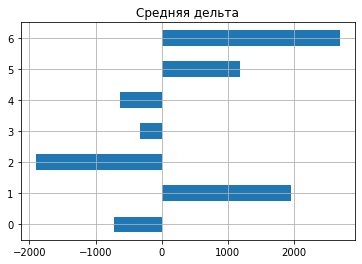

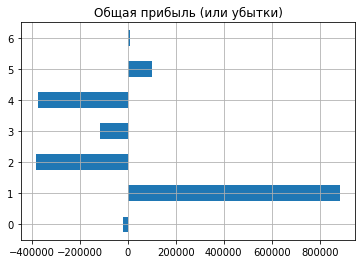

In [69]:
svod.delta.plot(kind='barh', grid=True).set_title('Средняя дельта')
plt.show()
svod.itog.plot(kind='barh', grid=True).set_title('Общая прибыль (или убытки)')
plt.show()

#### Исходя из этого у меня две рекомендации бизнесу:
- стараться привлекать(удерживать) больше клиентов прибыльных кластеров таргетируясь на аудитории по целям кредита, доходам, возрасту и др., предлагать интересные условия
- нивелировать убытки кредитной ставкой или другими возможными инструментами

Стоит отметить, что абсолютная прибыль не единственный важный показатель, средних доход с клиента тоже играет важную роль, 1 млн прибыли с одного клиента не равен 1 млн с десяти (с точки зрения операционных расходов и т д).

Рассмотрим другие признаки в разрезе кластеров:

In [60]:
# Для этого закодироуем образование по возрастанию 
# (мало записей у неоконченного второго образования и PhD, объединим их с высшим в одну категорию)
df.loc[df.education=='Secondary education', 'education_2'] = 1
df.loc[df.education=='Secondary special education', 'education_2'] = 2
df.loc[df.education=='Incomplete higher education', 'education_2'] = 3
df.loc[df.education.isin(['Higher education', 'Incomplete secondary education', 'PhD degree']), 'education_2'] = 4

cols = ['credit_term', 'age', 'sex', 'education', 'having_children_flg', 'region', 'income', 'is_client', 'cluster', 'education_2']
pd.concat([pd.DataFrame(df.cluster.value_counts()), svod.delta, df[cols].pivot_table(index='cluster')], axis=1)

,cluster,delta,age,credit_term,education_2,having_children_flg,income,is_client,region
0,30,-718.666667,45.600000,12.000000,2.333333,0.466667,31600.000000,0.566667,2.000000
1,451,1960.975610,37.243902,12.875831,3.933481,0.447894,41669.623060,0.556541,1.432373
2,201,-1903.383085,37.925373,11.049751,1.000000,0.388060,27134.328358,0.681592,1.756219
3,355,-328.901408,36.115493,11.321127,2.805634,0.436620,32523.943662,0.611268,1.723944
4,597,-625.963149,34.926298,10.865997,2.016750,0.433836,27686.767169,0.616415,1.825796
5,86,1180.000000,26.569767,11.244186,3.000000,0.313953,33860.465116,0.569767,1.511628
6,3,2700.000000,43.666667,11.333333,2.333333,1.000000,26000.000000,1.000000,2.000000


Если сравнивать между собой самые многочисленные кластеры - 3 и 4, то кроме того, что категория 4 является наиболее интересной с точки зрения потенциальной прибыли, про них можно сказать:
- они похожи с точки зрения возраста и наличия детей
- клиенты категории 4 имеют образование и доход существенно выше, чем в категории 3

Стоит отметить:
- кластер 1 - 5 человек с высшим образованием и вторым по величине средним доходом, и наивысшим (по нашему расчету) потенциальному удельному доходу
- кластер 5 - 11 человек с наимбольшим средним доходом, малым количеством детей и образованием чуть выше, чем средние специальное

Наверняка у них и разные цели кредита:

In [61]:
df.pivot_table(index='product_type', columns='cluster', values='age',  aggfunc='count')

cluster,0,1,2,3,4,5,6
product_type,,,,,,,
Audio & Video,NaN,2.0,2.0,3.0,2.0,NaN,NaN
Auto,NaN,4.0,3.0,5.0,8.0,1.0,NaN
Boats,NaN,7.0,NaN,1.0,3.0,NaN,NaN
Cell phones,NaN,78.0,78.0,112.0,204.0,26.0,NaN
Childen's goods,NaN,1.0,NaN,NaN,1.0,NaN,NaN
Clothing,NaN,42.0,4.0,13.0,25.0,4.0,NaN
Computers,NaN,44.0,20.0,37.0,62.0,15.0,NaN
Construction Materials,30.0,NaN,NaN,NaN,NaN,NaN,NaN
Cosmetics and beauty services,NaN,38.0,1.0,14.0,1.0,1.0,NaN


Все верно:
- в кластере 4 больше выбирали (отн-но этих же пунктов кластера 3) - образование, туризм, медицину, спорт, а 3 - телефоны, домашнюю технику, компьютеры
- кластер 2 практиески полностью представлен из кредитов на косметику и красоту
- кластер 5 - все 11 кредитов на лодки (?)

При этом картина "проблемности" по целям кредитов выглядит ожидаемо:

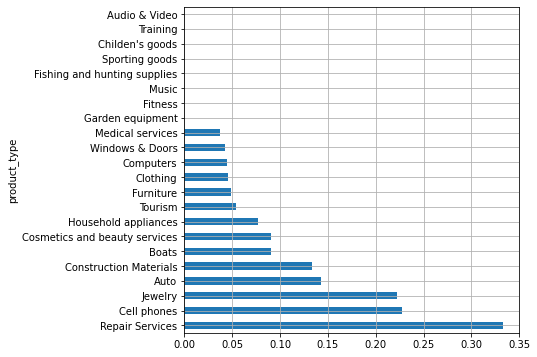

In [62]:
df.pivot_table(index='product_type', values='bad_client_target').sort_values('bad_client_target', 
                                                                        ascending=False).plot(kind='barh', grid=True, figsize=(6,6), legend=False);

#### Резюмируя можно сказать, что кластеры довольно неплохо разделили пользователей, в том числе по целям кредита, которые хорошо харакетризуют клиентов, что отражается и на финансовых показателях

______________________________________________

______________________________________________

______________________________________________

# ИСХОДНЫЙ КОД:


# Задание на аналитику результатов кластеризации.


### Как правило, получить бизнес интерпретируемый результат кластеризации достаточно сложная задача для аналитика. Вам предлагается ее решить.

Ниже представлен простой пайплайн кластеризации. Описание датасета - https://www.kaggle.com/podsyp/is-this-a-good-customer

## Ваша задача:
- Проанализировать результат кластеризации - clusters.csv (https://www.kaggle.com/podsyp/clustering-for-business-tasks/data)
- Описать каждый кластер и какой сегмент клиентов он характеризует.
- Сделать выводы о данной кластеризации. Какие плюсы и минусы в используемых подходах и результатах?
- Какие бизнес задачи вы бы решали, с помощью представленных кластеров?
- Какие улучшения вы бы предложили?


#### * Результатом работы лучше всего будет презентация, плюс excel или JupyterNotebook для проверки ваших расчетов.

# 1. Some imports.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm

!pip install pandas_summary
import pandas_summary as ps
import pandas_profiling

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# 2. Set options

In [6]:
get_ipython().magic('matplotlib inline')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [7]:
my_seed = 13

# 3. Read CSV

In [8]:
df = pd.read_csv('clients.csv')

In [9]:
df.shape

(1723, 14)

# 4. Quick EDA

In [10]:
df_4_cluster = df.copy()

In [11]:
df_4_cluster.head()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [12]:
df_4_cluster.tail()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
1718,12,18500,6,32,male,Higher education,Cell phones,1,2,46000,Another,1,1,0
1719,12,6500,6,24,male,Secondary special education,Cell phones,0,2,18000,Another,0,1,0
1720,12,5500,12,21,male,Incomplete higher education,Cell phones,0,2,15000,Another,1,1,0
1721,12,30500,10,25,female,Incomplete higher education,Cell phones,0,2,41000,Another,2,1,1
1722,12,116000,24,34,male,Higher education,Clothing,1,2,41000,Another,2,0,0


In [13]:
df_4_cluster.shape

(1723, 14)

## 4.1. Histogram

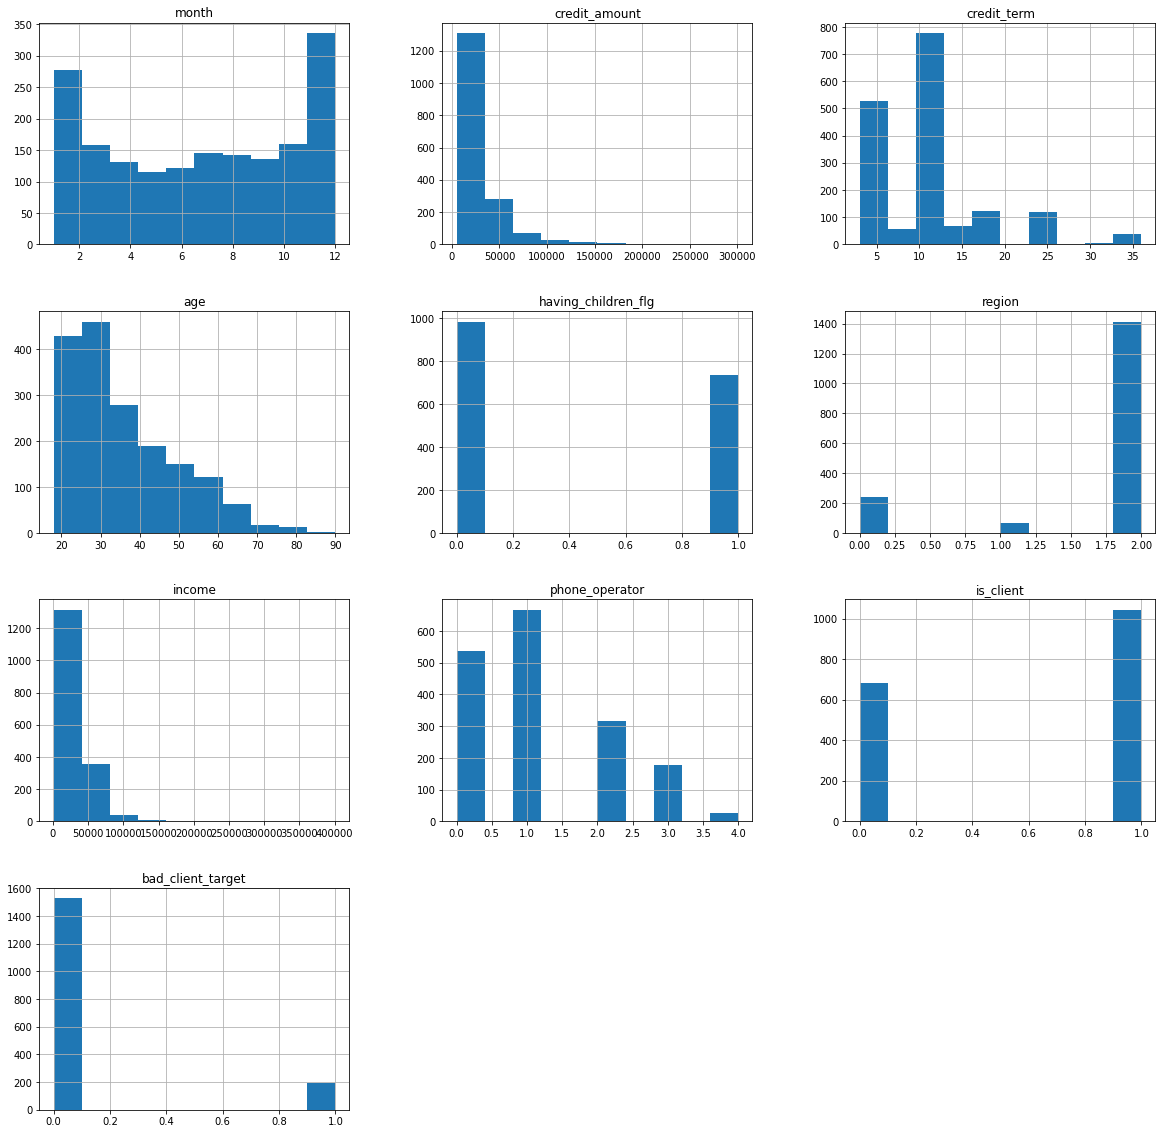

In [14]:
df_4_cluster.hist(figsize=(20,20));

In [30]:
dfs = ps.DataFrameSummary(df_4_cluster)
dfs.summary()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
count,1723.0,1723.0,1723.0,1723.0,1723.0,NaN,NaN,1723.0,1723.0,1723.0,NaN,1723.0,1723.0,1723.0
mean,6.708067,29264.654672,11.546721,35.911782,0.459663,NaN,NaN,0.428323,1.68137,32652.350551,NaN,1.125363,0.604759,0.113755
std,3.53842,27926.778301,6.548354,13.120203,0.498515,NaN,NaN,0.494979,0.704256,20913.193158,NaN,1.015822,0.489044,0.317606
min,1.0,5000.0,3.0,18.0,0.0,NaN,NaN,0.0,0.0,1000.0,NaN,0.0,0.0,0.0
25%,3.0,13000.0,6.0,26.0,0.0,NaN,NaN,0.0,2.0,21000.0,NaN,0.0,0.0,0.0
50%,7.0,21500.0,12.0,32.0,0.0,NaN,NaN,0.0,2.0,27000.0,NaN,1.0,1.0,0.0
75%,10.0,34000.0,12.0,44.0,1.0,NaN,NaN,1.0,2.0,38000.0,NaN,2.0,1.0,0.0
max,12.0,301000.0,36.0,90.0,1.0,NaN,NaN,1.0,2.0,401000.0,NaN,4.0,1.0,1.0
counts,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723
uniques,12,205,22,66,2,6,22,2,3,76,3,5,2,2


## 4.3. DF profile report

In [16]:
#pandas_profiling.ProfileReport(df_4_cluster, minimal=True)

# 5. Prepare DF

## 5.1. Binary

In [31]:
mapper = dict((val, i) for i, val in enumerate(df_4_cluster.sex.unique()))
mapper

{0: 0, 1: 1}

In [32]:
df_4_cluster['sex'] = df_4_cluster['sex'].map(mapper)

## 5.2. Categorical features

In [33]:
categoricals = dfs.categoricals.tolist()
categoricals

['education', 'product_type', 'family_status']

In [34]:
df_4_cluster = pd.get_dummies(df_4_cluster, columns=categoricals, drop_first=False)

## 5.3. Drop month - drop trend

In [35]:
df_4_cluster.drop('month', axis=1, inplace=True)

# 6. Scale features

In [36]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_4_cluster)
df_scaled = pd.DataFrame(df_scaled, columns=df_4_cluster.columns)
df_scaled.shape

(1723, 41)

In [37]:
df_scaled.head()

,credit_amount,credit_term,age,sex,having_children_flg,region,income,phone_operator,is_client,bad_client_target,education_Higher education,education_Incomplete higher education,education_Incomplete secondary education,education_PhD degree,education_Secondary education,education_Secondary special education,product_type_Audio & Video,product_type_Auto,product_type_Boats,product_type_Cell phones,product_type_Childen's goods,product_type_Clothing,product_type_Computers,product_type_Construction Materials,product_type_Cosmetics and beauty services,product_type_Fishing and hunting supplies,product_type_Fitness,product_type_Furniture,product_type_Garden equipment,product_type_Household appliances,product_type_Jewelry,product_type_Medical services,product_type_Music,product_type_Repair Services,product_type_Sporting goods,product_type_Tourism,product_type_Training,product_type_Windows & Doors,family_status_Another,family_status_Married,family_status_Unmarried
0,-0.797483,0.069240,0.235447,-0.922333,-0.865586,0.452567,-0.557339,-1.108156,-1.236973,-0.358268,-0.71698,-0.229205,-0.053948,-0.041763,-0.370532,1.030051,-0.072463,-0.111078,-0.080158,1.568388,-0.03409,-0.231997,-0.339427,-0.133117,-0.181586,-0.024098,-0.121339,-0.324339,-0.041763,-0.613350,-0.146081,-0.126174,-0.024098,-0.041763,-0.059114,-0.14814,-0.076405,-0.16746,0.659271,-0.589191,-0.217753
1,-0.367663,-0.847286,-1.213122,-0.922333,1.155287,0.452567,-0.748661,1.845975,0.808425,-0.358268,-0.71698,-0.229205,-0.053948,-0.041763,-0.370532,1.030051,-0.072463,-0.111078,-0.080158,-0.637598,-0.03409,-0.231997,-0.339427,-0.133117,-0.181586,-0.024098,-0.121339,-0.324339,-0.041763,1.630391,-0.146081,-0.126174,-0.024098,-0.041763,-0.059114,-0.14814,-0.076405,-0.16746,0.659271,-0.589191,-0.217753
2,-0.009479,0.069240,-0.984400,1.084207,-0.865586,0.452567,-0.079033,0.861264,-1.236973,-0.358268,-0.71698,-0.229205,-0.053948,-0.041763,-0.370532,1.030051,-0.072463,-0.111078,-0.080158,-0.637598,-0.03409,-0.231997,-0.339427,-0.133117,-0.181586,-0.024098,-0.121339,-0.324339,-0.041763,1.630391,-0.146081,-0.126174,-0.024098,-0.041763,-0.059114,-0.14814,-0.076405,-0.16746,0.659271,-0.589191,-0.217753
3,-0.690028,0.069240,-0.450717,-0.922333,1.155287,0.452567,-0.079033,1.845975,0.808425,-0.358268,-0.71698,-0.229205,-0.053948,-0.041763,-0.370532,1.030051,-0.072463,-0.111078,-0.080158,1.568388,-0.03409,-0.231997,-0.339427,-0.133117,-0.181586,-0.024098,-0.121339,-0.324339,-0.041763,-0.613350,-0.146081,-0.126174,-0.024098,-0.041763,-0.059114,-0.14814,-0.076405,-0.16746,-1.516828,-0.589191,4.592357
4,-0.528845,0.069240,-0.831919,1.084207,-0.865586,0.452567,-0.318186,-1.108156,0.808425,-0.358268,1.39474,-0.229205,-0.053948,-0.041763,-0.370532,-0.970826,-0.072463,-0.111078,-0.080158,1.568388,-0.03409,-0.231997,-0.339427,-0.133117,-0.181586,-0.024098,-0.121339,-0.324339,-0.041763,-0.613350,-0.146081,-0.126174,-0.024098,-0.041763,-0.059114,-0.14814,-0.076405,-0.16746,-1.516828,1.697242,-0.217753


# 6. PCA for correlation in features

In [38]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=my_seed)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)
df_pca.shape

(1723, 35)

In [39]:
pca.explained_variance_

array([2.63317762, 1.96747969, 1.77746456, 1.63244824, 1.49316579,
       1.30259448, 1.23701919, 1.22852471, 1.17406028, 1.15090933,
       1.1323733 , 1.10004686, 1.09590165, 1.08684183, 1.07126934,
       1.04064794, 1.03112202, 1.02569454, 1.01779996, 1.01353282,
       1.00847401, 1.0052676 , 1.00226985, 0.97836268, 0.96836493,
       0.94667853, 0.93222968, 0.90230659, 0.88588306, 0.87057742,
       0.85973295, 0.84434332, 0.7793238 , 0.74851017, 0.63567517])

# 7. TSNE for visualization

In [40]:
tsne = TSNE(n_components=2, random_state=my_seed)

In [41]:
df_tsne = tsne.fit_transform(df_pca)
df_tsne.shape

(1723, 2)

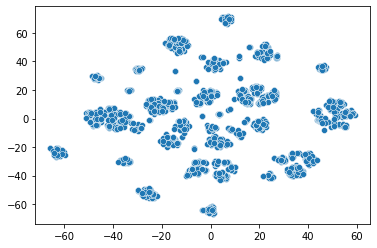

In [42]:
sns.scatterplot(df_tsne[:,0], df_tsne[:,1])

# 8. Optimize number of clusters

## 8.1. Elbow method

In [45]:
inertia = []
for i in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=i, random_state=my_seed).fit(df_pca)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


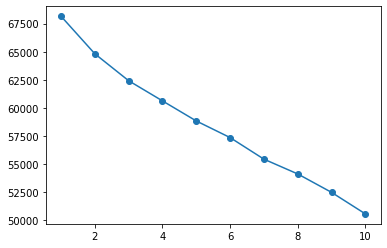

In [46]:
plt.plot(range(1, 11), inertia, marker='o');

In [47]:
D = []
for i in range(1, 9):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

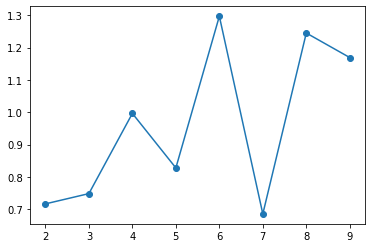

In [48]:
plt.plot(range(2, 10), D, marker='o');

#### Elbow method not effective

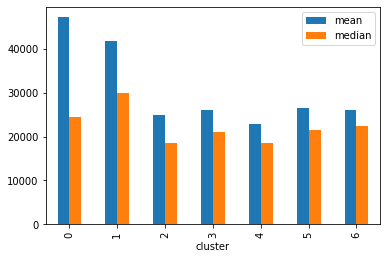

In [57]:
df.pivot_table(index='cluster', values='credit_amount', aggfunc=('mean', 'median')).plot(kind='bar');

Посчитаем потенциальную прибыль с каждой категории, возьмем процент кредита равным 12 (с целью упрощения расчета, берем один процент на всех):

In [58]:
percent = 0.12
risk = df.pivot_table(index='cluster', values='bad_client_target') # доля "плохих" заемщиков
cl_cr_amount = df.pivot_table(index='cluster', values='credit_amount', aggfunc=('median')) # медианная сумма кредита внутри кластера

svod = pd.concat([pd.DataFrame(df.cluster.value_counts()), cl_cr_amount, risk], axis=1)
svod.columns = ['count', 'median_amount', 'risk']
svod['profit'] = svod['median_amount'] * percent * (1 - svod['risk']) # средний заработок с клиента с учетом ставки в 12% и вероятности выплаты
svod['losses'] = svod['median_amount'] * svod['risk'] # средние убытки
svod['delta']  = svod['profit'] - svod['losses'] # разница между потерями и прибылью
svod['itog']   = svod['delta'] * svod['count'] # разница умноженная на количество клиентов в кластере
svod

,count,median_amount,risk,profit,losses,delta,itog
0,30,24500,0.133333,2548.000000,3266.666667,-718.666667,-21560.0
1,451,30000,0.048780,3424.390244,1463.414634,1960.975610,884400.0
2,201,18500,0.199005,1778.208955,3681.592040,-1903.383085,-382580.0
3,355,21000,0.121127,2214.760563,2543.661972,-328.901408,-116760.0
4,597,18500,0.137353,1915.075377,2541.038526,-625.963149,-373700.0
5,86,21500,0.058140,2430.000000,1250.000000,1180.000000,101480.0
6,3,22500,0.000000,2700.000000,0.000000,2700.000000,8100.0


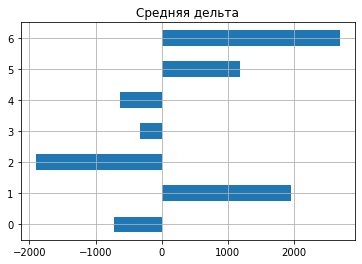

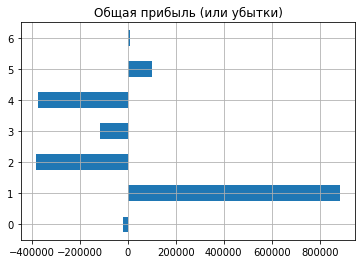

In [59]:
svod.delta.plot(kind='barh', grid=True).set_title('Средняя дельта')
plt.show()
svod.itog.plot(kind='barh', grid=True).set_title('Общая прибыль (или убытки)')
plt.show()

## 8.2. Silhouette Coefficient

This node computes the Silhouette Coefficient for the provided clustering result. The Silhouette Coefficient is a useful metric for evaluating clustering performance. For each row, it is computed using (b - a) / max(a, b) , where a is the mean intra-cluster distance and b is the mean inter-cluster distance to the closest cluster. Additionally, a second table containing the mean over all individual Silhouette Coefficients is calculated. The score can range from -1.0 to 1.0, while the higher the score, the better. There have to be at least two clusters for the score to be computable.

By default, the Euclidean distance is used to calculate distances between rows. This may be changed by providing an optional distance function. If a distance function is supplied, the data column selection in the dialog will be ignored as the used columns are configured by the connected distance function.

In [50]:
silhouette = []
for i in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters=i, random_state=my_seed).fit(df_pca)
    labels = kmeans.labels_
    score = silhouette_score(df_pca, labels)
    silhouette.append(score)

100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


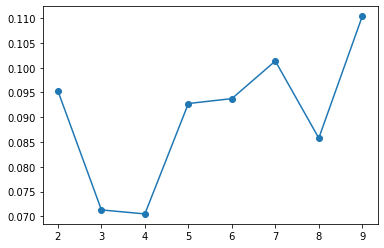

In [51]:
plt.plot(range(2, 10), silhouette, marker='o');

## 8.3. Results by number of clusters

For n_clusters = 2 The average silhouette_score is : 0.09530864588983769
For n_clusters = 3 The average silhouette_score is : 0.030941219528219033
For n_clusters = 4 The average silhouette_score is : 0.07349859145634965
For n_clusters = 5 The average silhouette_score is : 0.08714940295866677
For n_clusters = 6 The average silhouette_score is : 0.09834314871484011
For n_clusters = 7 The average silhouette_score is : 0.0965026066201039
For n_clusters = 8 The average silhouette_score is : 0.12615064488947048
For n_clusters = 9 The average silhouette_score is : 0.1030989653697833


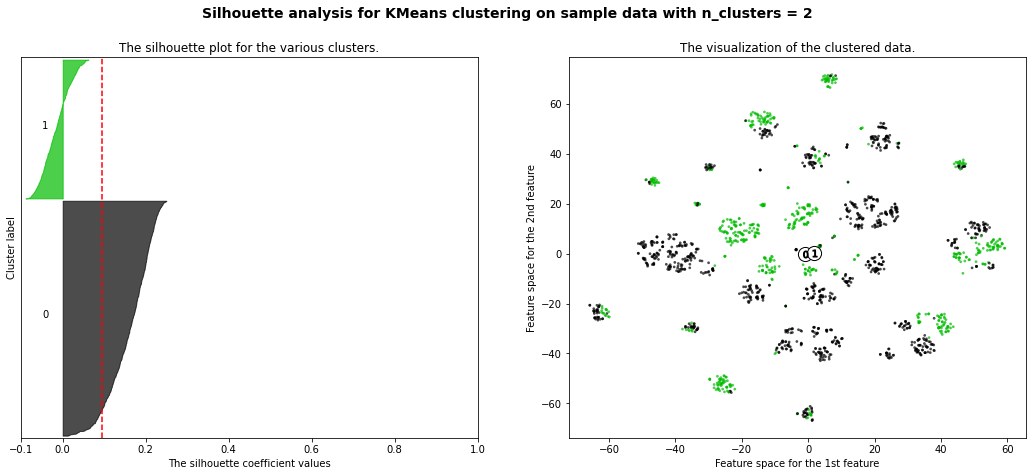

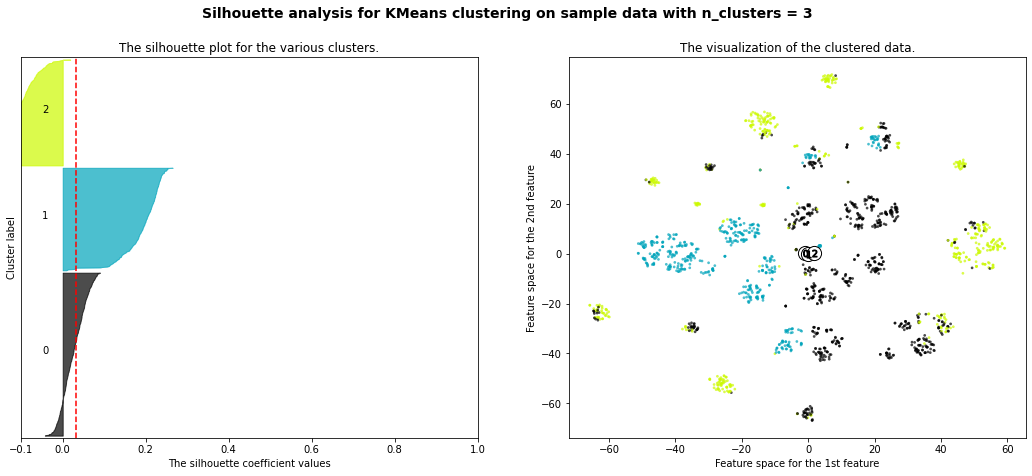

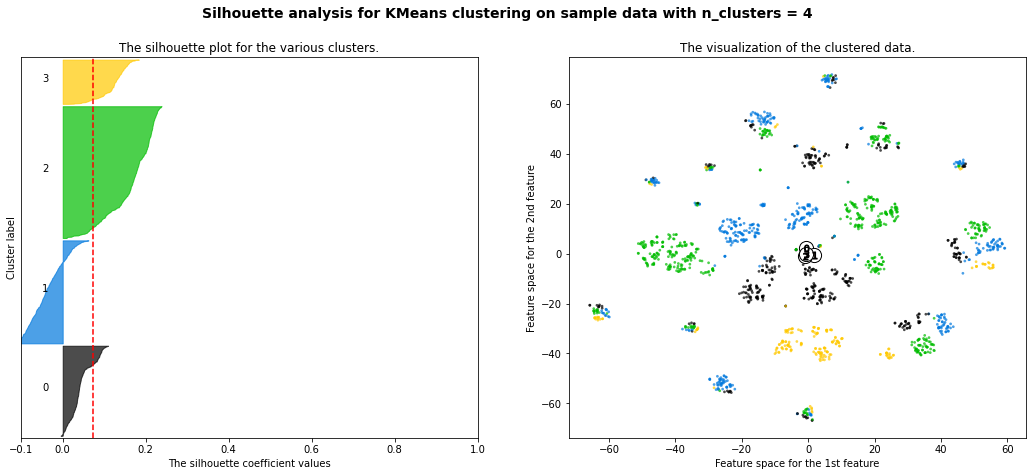

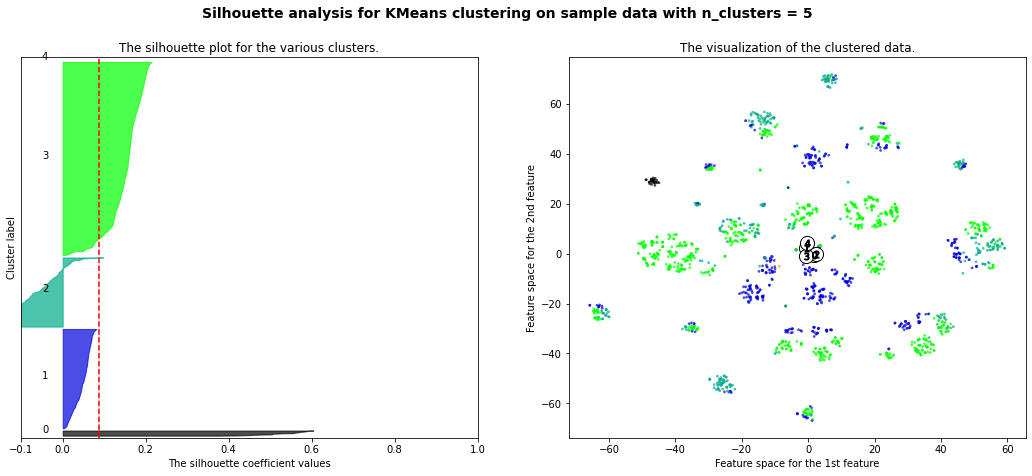

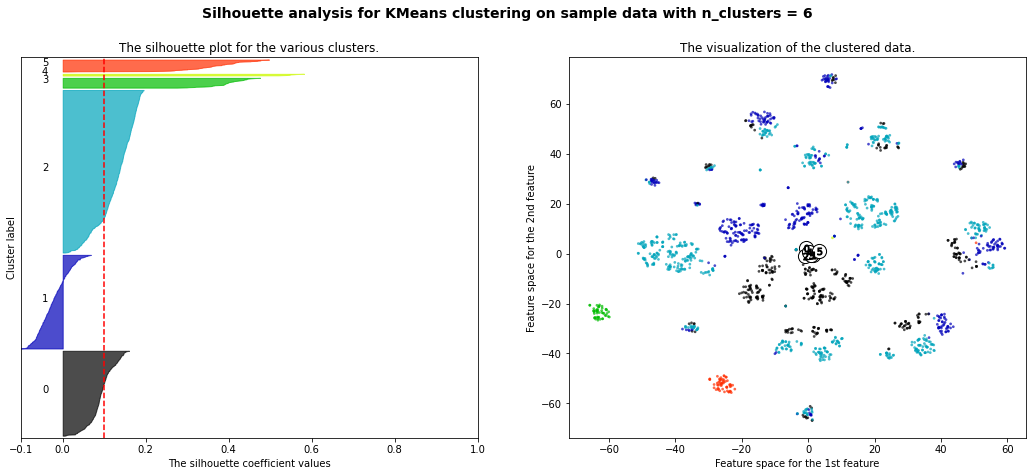

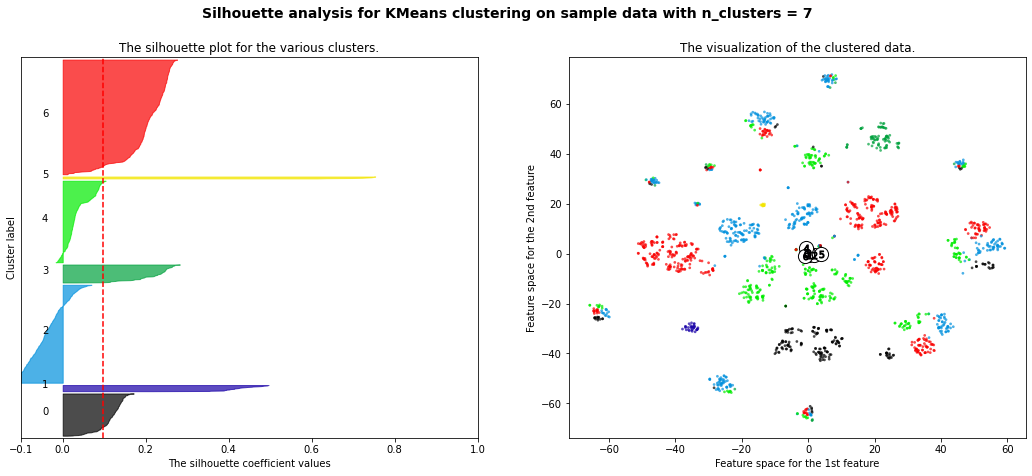

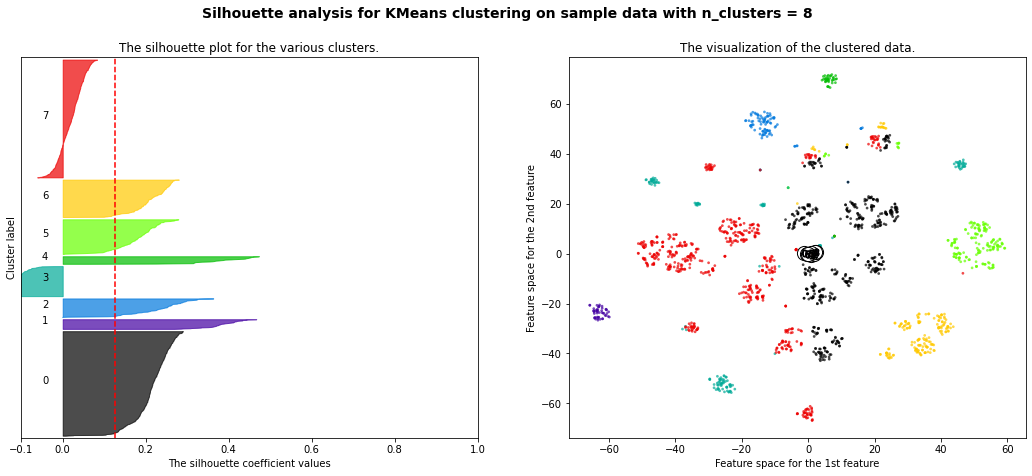

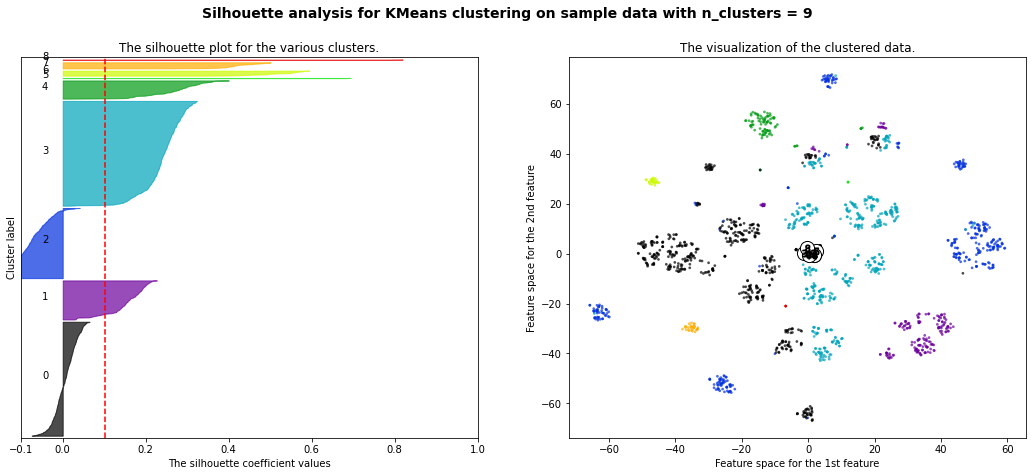

In [52]:
range_n_clusters = list(range(2, 10))
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_tsne[:, 0], df_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# 9. Uploading totals

In [54]:
kmeans = KMeans(n_clusters=7, random_state=my_seed).fit(df_pca)
pd.Series(kmeans.labels_).value_counts()

4    597
1    451
3    355
2    201
5     86
0     30
6      3
dtype: int64

In [55]:
df['cluster'] = kmeans.labels_
df.head()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target,cluster
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0,4
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0,4
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0,4
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0,4
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0,3


In [ ]:
df.to_csv('clusters.csv', index=False)

________________________________________________________